## Trabajo Fin de Máster <br/> Diseño de una arquitectura multimodal para descripción textual de pares imagen-audio

## Script 7. Detección de caras en una imagen y aplicación del modelo completo

En este notebook, hacemos uso de la librería FaceNet para detectar las caras que hay en una imagen con varias personas, y posteriormente aplicamos el modelo obtenido en el notebook 6 para discernir quién es dentro de nuestra base de datos.

In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install torch==2.3.0 torchaudio==2.3.0 facenet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.8 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-_15l8xh7
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-_15l8xh7
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 21.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of facenet-pytorch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 34.8 MB/s eta 0:00:00


### Paso 1. Montamos el almacenamiento

Damos permiso a Colab para acceder a mi unidad de Drive y nos situamos en la carpeta donde tenemos los scripts y la librería que hemos creado con las clases propias.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/TFM/Proyecto/Scripts

Mounted at /content/drive
/content/drive/MyDrive/TFM/Proyecto/Scripts


### Paso 2. Iniciamos sesión para registrar los resultados en wandb

### Paso 3. Definición de parámetros y configuración

### Paso 4. Lectura de los datos de prueba

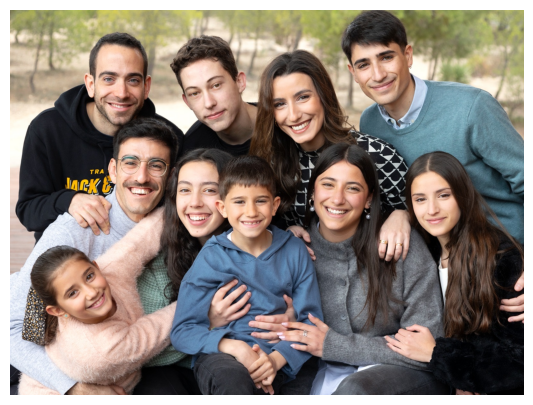

In [4]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt

imagen_1 = Image.open('/content/drive/MyDrive/TFM/Proyecto/IMG_grupo2.JPG')

plt.figure(figsize=(7, 5))
plt.imshow(imagen_1)
plt.axis('off');

### Paso 5. Detección de caras con FaceNet

In [5]:
import torch
from facenet_pytorch import MTCNN
import numpy as np

# Detectar si se dispone de GPU cuda
# ==============================================================================
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

# Detector MTCNN
# ==============================================================================
mtcnn = MTCNN(
            select_largest = True,
            min_face_size  = 20,
            thresholds     = [0.6, 0.7, 0.7],
            post_process   = False,
            image_size     = 160,
            device         = device
        )

Running on device: cuda:0


In [6]:
boxes, probs, landmarks = mtcnn.detect(imagen_1, landmarks=True)
print('Bounding boxes:', boxes)
print('Probability:', probs)
print('landmarks:', landmarks)

Bounding boxes: [[256.00799560546875 110.90693664550781 421.4862976074219
  352.52008056640625]
 [539.2633056640625 156.75680541992188 718.5309448242188
  374.96063232421875]
 [804.7548828125 192.1372833251953 976.5816650390625 415.21881103515625]
 [948.5645141601562 456.88665771484375 1114.702392578125 684.2626953125]
 [514.3195190429688 465.908203125 675.468017578125 699.0728759765625]
 [328.12591552734375 394.7916259765625 492.59326171875 621.7637939453125]
 [1065.2528076171875 93.84101867675781 1232.4635009765625
  289.8092346191406]
 [137.76449584960938 777.2350463867188 316.7962341308594
  958.3060913085938]
 [1246.301513671875 503.183837890625 1397.7061767578125 696.2910766601562]
 [676.1616821289062 531.1257934570312 818.006591796875 704.5780029296875]]
Probability: [0.9999983310699463 0.9999991655349731 0.9999246597290039
 0.9999995231628418 0.999998927116394 0.999962568283081 0.9992569088935852
 0.9995540976524353 0.9999785423278809 0.9999105930328369]
landmarks: [[[309.33618

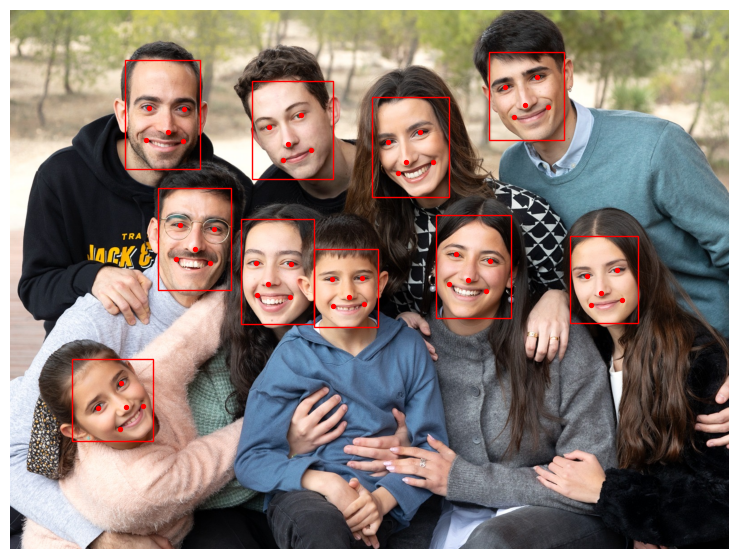

In [7]:
# Representación con matplotlib
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 7))
ax.imshow(imagen_1)

for box, landmark in zip(boxes, landmarks):
    ax.scatter(landmark[:, 0], landmark[:, 1], s=8, c= 'red')
    rect = plt.Rectangle(
                xy     = (box[0], box[1]),
                width  = box[2] - box[0],
                height = box[3] - box[1],
                fill   = False,
                color  = 'red'
           )
    ax.add_patch(rect)

ax.axis('off');

In [8]:
# Detector MTCNN
# ==============================================================================
mtcnn = MTCNN(
            keep_all      = True,
            min_face_size = 20,
            thresholds    = [0.6, 0.7, 0.7],
            post_process  = False,
            image_size    = 224,
            device        = device
        )

# Detección de caras
# ==============================================================================
faces = mtcnn.forward(imagen_1)

faces.shape

torch.Size([10, 3, 224, 224])

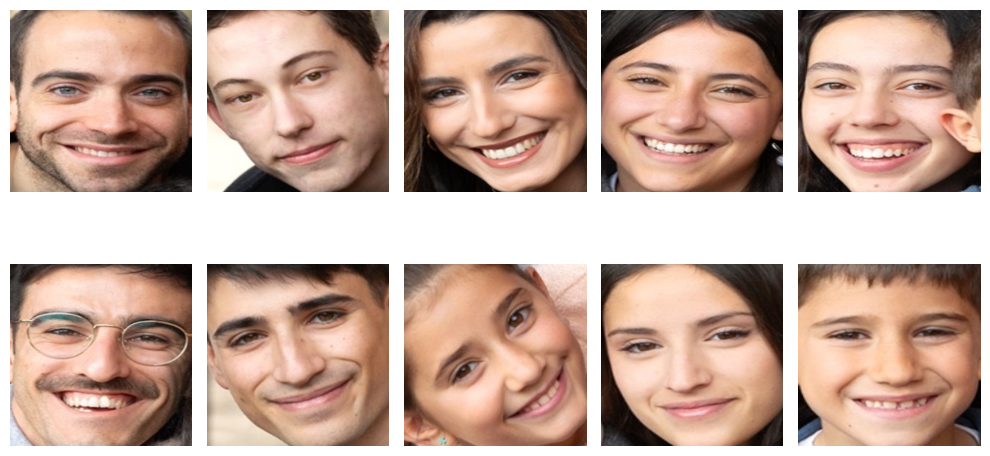

In [9]:
# Representación con matplotlib
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10, 6))
axs= axs.flatten()

for i in range(faces.shape[0]):
    face = faces[i,:,:,:].permute(1, 2, 0).int().numpy()
    axs[i].axis('off')
    axs[i].imshow(face)

plt.tight_layout();

Prueba

In [10]:
import clip
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from PIL import Image
import numpy as np
from IPython.display import Audio
from tfm_lib.audio_processing import AudioUtil, AudioAugmentation
from tfm_lib.modelos import AudioCLIP

# Descarga el modelo pre-entrenado y procesador de CLIP
device = "cuda" if torch.cuda.is_available() else "cpu"
model = AudioCLIP("RN50", device, 6).to(device)

model_parameters_file = '/content/drive/MyDrive/TFM/Proyecto/Scripts/modelos/FULL_RN50_6pers_lr1e-06_bs16_20epDA.h5'

# model.load_state_dict(torch.load(model_parameters_file, map_location=torch.device('cpu')))
model.load_state_dict(torch.load(model_parameters_file))
model.eval()

100%|███████████████████████████████████████| 244M/244M [00:05<00:00, 49.5MiB/s]


AudioCLIP(
  (clip_model): CLIP(
    (visual): ModifiedResNet(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu3): ReLU(inplace=True)
      (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [23]:
import torchvision.transforms as T
transform = T.ToPILImage()

read_image = faces[5,:,:,:].type(torch.uint8)
aud = AudioUtil.open('/content/drive/MyDrive/TFM/Proyecto/Final_Database_mini/audio/Jose Alberto Azorin Puche/audio0000.ogg')
aud = AudioUtil.resample(aud, 48000)
aud = AudioUtil.rechannel(aud, 1)
aud = AudioAugmentation.pad_trunc(aud, 4)
sgram = AudioUtil.spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None).unsqueeze(0).to(device)

image = model.preprocess(transform(read_image)).unsqueeze(0).to(device)
people = ['Genesis Reyes Arteaga', 'Jose Alberto Azorin Puche', 'Juan Cuesta Lopez',
          'Juanjo Bautista Ibanez', 'Maria Jose Morales Forte', 'Noelia Sanchez Alonso']
text = torch.cat([clip.tokenize(f"a photo of a {c}") for c in people]).to(device)

with torch.no_grad():
  output = model(image, text, sgram)

print(output.softmax(dim=-1))

tensor([[0.2097, 0.0678, 0.0985, 0.2507, 0.2474, 0.1258]], device='cuda:0')


In [22]:
read_image = Image.open('/content/drive/MyDrive/TFM/Proyecto/IMG_0002.jpg')
aud = AudioUtil.open('/content/drive/MyDrive/TFM/Proyecto/Final_Database_mini/audio/Jose Alberto Azorin Puche/audio0000.ogg')
aud = AudioUtil.resample(aud, 48000)
aud = AudioUtil.rechannel(aud, 1)
aud = AudioAugmentation.pad_trunc(aud, 4)
sgram = AudioUtil.spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None).unsqueeze(0).to(device)

image = model.preprocess(read_image).unsqueeze(0).to(device)
people = ['Genesis Reyes Arteaga', 'Jose Alberto Azorin Puche', 'Juan Cuesta Lopez',
          'Juanjo Bautista Ibanez', 'Maria Jose Morales Forte', 'Noelia Sanchez Alonso']
text = torch.cat([clip.tokenize(f"a photo of {c}") for c in people]).to(device)

with torch.no_grad():
  output = model(image, text, sgram)

print(output.softmax(dim=-1))

tensor([[0.3819, 0.0398, 0.2657, 0.0532, 0.1646, 0.0949]], device='cuda:0')
